# Imports y configuraciones iniciales

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from quickdraw import QuickDrawDataGroup

from bwb.distributions import DistributionDraw

Importamos los datos utilizando el archivo npy que proporciona Google Cloud.

In [2]:
data = np.load(r"..\data\face.npy")
data.shape

(161666, 784)

Hacemos una lista de caritas, fijando un generador con la semilla 42 para tener resultados replicables.

In [3]:
rng = np.random.default_rng(42)
faces: list[DistributionDraw] = list()
n_faces = len(data)

for i in range(n_faces):
    arr = 255 - data[i, :].reshape(28, 28)
    dd_arr = DistributionDraw.fromarray(arr, seed=rng)
    faces.append(dd_arr)

Observamos la primera carita

In [4]:
faces[0].image

Muestrear con respecto a una carita (la primera para simplificar)

In [5]:
n = 30
x = faces[0].rvs(size=n)
x

[(21, 15),
 (11, 10),
 (22, 18),
 (20, 7),
 (4, 16),
 (24, 15),
 (21, 12),
 (21, 19),
 (5, 18),
 (11, 15),
 (10, 8),
 (23, 17),
 (18, 24),
 (22, 8),
 (11, 14),
 (8, 9),
 (13, 25),
 (4, 10),
 (22, 9),
 (18, 2),
 (21, 12),
 (10, 2),
 (24, 14),
 (23, 8),
 (21, 16),
 (7, 21),
 (11, 18),
 (4, 5),
 (6, 20),
 (19, 25)]

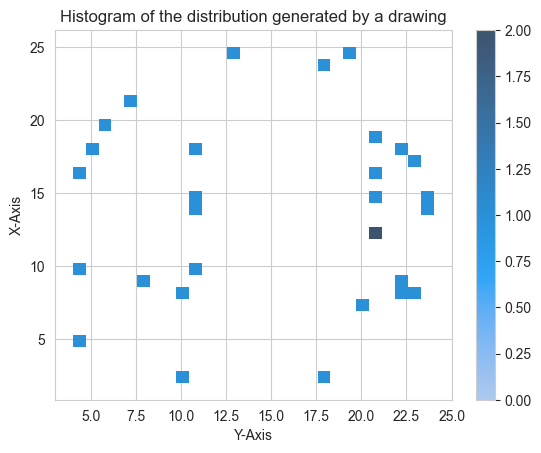

In [6]:
from bwb.utils import plot_histogram_from_points

plot_histogram_from_points(x, histplot_kwargs=dict(bins=28))
plt.show()

Defino
\begin{equation}
\tilde\Lambda_n(m) = \prod_{i=1}^{n} f_m(x_i)
\end{equation}

A través de la función `likelihood`

In [7]:
def likelihood(mu: DistributionDraw, data: list[tuple[int, int]]):
    evaluations = []
    for i in range(len(data)):
        evaluations.append(mu.matrix[data[i]])
    return np.prod(evaluations)
likelihood(mu=faces[0], data=x)

9.074242862561625e-72

# Metropolis Algorithm

En esta sección se implementa el *Metropolis Algorithm*. Este posee la siguiente matriz $R$:
\begin{equation}
R_{\mu, \nu} = (\text{degr}(\mu))^{-1} = \frac{1}{|\mathcal{M} - 1|}
\end{equation}
donde lo último es por la forma que posee el grafo escogido.

In [8]:
%%time
EPS = 1e-16  # Holgura para el determinador, para evitar dividir por 0

N = 10  # 10_000
mu = []

# Paso 1. Empezar con una distribución inicial mu^(0) \in M
current_face = int(rng.choice(n_faces))
mu.append(faces[current_face])  # mu^(0)

# Paso 2.
for i in range(N):
    # Paso a. muestrear u ~ U[0, 1]
    u = rng.uniform(low=0, high=1)

    # Paso b. muestrear mu^star de acuerdo a R partiendo desde mu^(i)
    possible_faces = list(range(n_faces))
    possible_faces.remove(current_face)
    # Escoger una carita
    next_face = int(rng.choice(possible_faces))
    mu_star = faces[next_face]

    # Paso c.
    # Luego calculamos la probabilidad de aceptación
    A_mu_i_mu_star = min(1, (likelihood(mu_star, data=x))
                            / (likelihood(mu[i], data=x) + EPS))

    print("=" * 10)
    print(f"{i = }")
    print(f"{A_mu_i_mu_star = }")
    if u < A_mu_i_mu_star:
        mu.append(mu_star)

        print(f"{current_face = } -> {next_face = }")
        print(f"{u = }")

    else:
        mu.append(mu[i])

    # Moverse a la siguiente carita
    current_face = next_face

i = 0
A_mu_i_mu_star = 0.0
i = 1
A_mu_i_mu_star = 0.0
i = 2
A_mu_i_mu_star = 0.0
i = 3
A_mu_i_mu_star = 0.0
i = 4
A_mu_i_mu_star = 0.0
i = 5
A_mu_i_mu_star = 0.0
i = 6
A_mu_i_mu_star = 0.0
i = 7
A_mu_i_mu_star = 0.0
i = 8
A_mu_i_mu_star = 0.0
i = 9
A_mu_i_mu_star = 0.0
CPU times: total: 172 ms
Wall time: 178 ms


Empecemos observando las distintas imágenes que generó

In [9]:
# Primera imagen generada
mu[0].image

In [10]:
# Última imagen generada
mu[-1].image

# Gibbs Sampler

Ahora empecemos a generar la otra variación del algoritmo: *Gibbs Sampler*. Después de unos cálculos, este posee la siguiente matriz $R$:
\begin{equation}
R_{\mu, \nu} = \frac{
\tilde \Lambda_n(\nu)
}{
\sum_{\tilde \nu \in \mathcal{M}} \tilde \Lambda_n(\tilde \nu) - \tilde \Lambda_n(\mu)
}
\end{equation}
con la función $\tilde\Lambda_n$ definida como antes.

Notemos que, la gran diferencia con el otro algoritmo es la forma de calcular la matriz $R$. Por este motivo se copiará y pegará el algoritmo anterior, modificando este valor.

In [11]:
%%time
likelihood_cache = np.array([likelihood(nu_tilde, data=x) for nu_tilde in faces])
# Cálculo de la sumatoria, que es un valor genérico para todos
sum_lambdas_n = sum(likelihood_cache)
sum_lambdas_n

CPU times: total: 11.3 s
Wall time: 11.4 s


9.074562456270114e-72

In [12]:
sum(likelihood_cache > 0)

9

In [13]:
%%time
EPS = 1e-16  # Holgura para el determinador, para evitar dividir por 0

N = 10_000
mu = []
possible_faces = list(range(n_faces))

# Paso 1. Empezar con una distribución inicial mu^(0) \in M
current_face = int(rng.choice(n_faces))
mu.append(faces[current_face])  # mu^(0)
probabilities = {i: None for i in range(n_faces)}

# Paso 2.
for i in range(N):
    # Paso a. muestrear u ~ U[0, 1]
    u = rng.uniform(low=0, high=1)

    # Paso b. muestrear mu^star de acuerdo a R partiendo desde mu^(i)
    # Calcular las probabilidades
    if probabilities[current_face] is None:
        print(f"Calculando las probabilidades de transición de la carita {i = }")
        probabilities[current_face] = np.array([
            likelihood_cache[face_i]
            / (sum_lambdas_n - likelihood_cache[current_face]) for face_i in possible_faces
        ])
        probabilities[current_face][current_face] = 0.
    # Escoger una carita
    next_face = int(rng.choice(possible_faces, p=probabilities[current_face]))
    mu_star = faces[next_face]

    # Paso c.
    # calculamos la probabilidad de aceptación
    A_mu_i_mu_star = min(1, (sum_lambdas_n - likelihood_cache[current_face])
                         / (sum_lambdas_n - likelihood_cache[next_face])
                         )

    print("=" * 10)
    print(f"{i = }")
    print(f"{A_mu_i_mu_star = }")
    if u < A_mu_i_mu_star:
        mu.append(mu_star)

        print(f"{current_face = } -> {next_face = }")
        print(f"{u = }")

    else:
        mu.append(mu[i])

    # Moverse a la siguiente carita
    current_face = next_face

Calculando las probabilidades de transición de la carita i = 0
i = 0
A_mu_i_mu_star = 1
current_face = 130103 -> next_face = 0
u = 0.38747837903017446
Calculando las probabilidades de transición de la carita i = 1
i = 1
A_mu_i_mu_star = 3.5219849065630436e-05
Calculando las probabilidades de transición de la carita i = 2
i = 2
A_mu_i_mu_star = 1
current_face = 124611 -> next_face = 0
u = 0.19990820247510832
i = 3
A_mu_i_mu_star = 3.5219849065630436e-05
i = 4
A_mu_i_mu_star = 1
current_face = 124611 -> next_face = 0
u = 0.7051653786263351
i = 5
A_mu_i_mu_star = 3.5219849065630436e-05
i = 6
A_mu_i_mu_star = 1
current_face = 124611 -> next_face = 0
u = 0.13979699812765745
i = 7
A_mu_i_mu_star = 3.5219849065630436e-05
i = 8
A_mu_i_mu_star = 1
current_face = 124611 -> next_face = 0
u = 0.5652361064811888
i = 9
A_mu_i_mu_star = 3.5219849065630436e-05
i = 10
A_mu_i_mu_star = 1
current_face = 124611 -> next_face = 0
u = 0.5592071607454135
i = 11
A_mu_i_mu_star = 3.5219849065630436e-05
i = 12
A

In [14]:
not_none_keys = []
for k, v in probabilities.items():
    if v is not None:
        not_none_keys.append(k)

len(not_none_keys)

6

Empecemos observando las distintas imágenes que generó

In [15]:
# Primera imagen generada
mu[0].image

In [16]:
import ipyplot
import warnings
warnings.filterwarnings("ignore")


random_samples = [faces[k].image for k in not_none_keys]

ipyplot.plot_images(random_samples, max_images=48, img_width=75)

In [17]:
# Última imagen generada
mu[-1].image

# Ideas y Conclusiones

Ideas para continuar:
* Dejar guardadas de alguna forma las simulaciones realizadas
* Intentar hacer el mismo experimento, pero haciendo que el soporte de las funciones sea distinto de 0 (es decir, que todos tengan el mismo soporte), para que la función $\tilde \Lambda_n$ no se anule, y no posea una probabilidad de aceptación nula

El experimento fue realizado con 161.666 caritas, en donde se muestreó a partir de la primera carita 3 puntos, es decir $D=\{x_i\}_{i=1}^{3} \sim m_0$ i.i.d.

A pesar de los pocos datos que se utilizó para calcular la posterior $\Pi_n$, aún se toma demasiado "saltos" (igual uno esperaría que se pueda probar con $n=100$ datos, por ejemplo). Esto se puede deber por la forma que posee la verosimilitud:
\begin{equation}
\bold{\Pi}_n(x_1,\ldots,x_n | m) = \tilde \Lambda_n(m) = \prod_{i=1}^{n} f_m(x_i).
\end{equation}

Cómo se están evaluando los puntos de los datos en la función de distribución del modelo $m$, entonces, si es que existe un punto $\tilde x \in D$ tal que $f_m(\tilde x) = 0$, hará que el valor de la verosimilitud sea idénticamente 0. De forma que, sin importar los otros valores, si $D \not\subseteq \text{sop}(m)$, entonces el valor asignado al modelo $m$ será de 0.

Es esta la razón por la que el algoritmo MCMC termina saltándose varias distribuciones. Una forma de arreglar esto, es el de asignar algún valor distinto de nulo, para darle mayor oportunidad a saltar a esas distribuciones. Esto es lo que se hará en el notebook siguiente.

Adicionalmente, se observa que el algoritmo de *Gibbs sampler* se demora 30 segundos más que el de *Metropolis algorithm*.